In [1]:
import torch
torch.cuda.empty_cache()

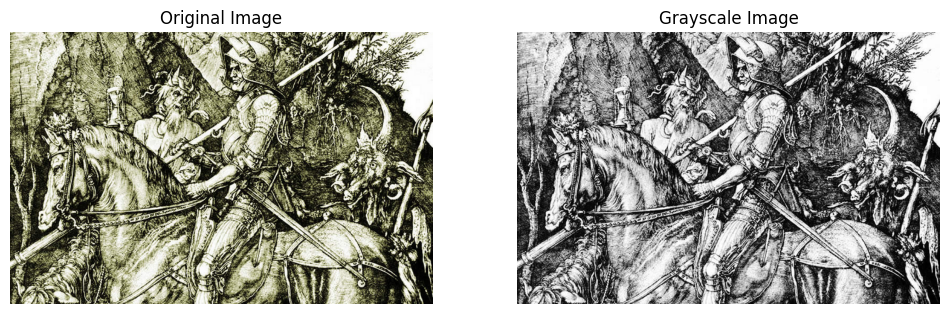

In [2]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'.\dataset\training_set'  # Update this path
output_directory_base = r'.\dataset\gray_training_set'  # Update this path




# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [3]:
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [5]:
from torch.utils.data import DataLoader
from torchvision import transforms
training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_training_set',
    color_dir=r'./dataset/training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_validation_set',
    color_dir=r'./dataset/validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)

In [6]:
for inputs, _ in DataLoader(training_data, batch_size=1, shuffle=True):
    print(f"Grayscale image size: {inputs.size()}")
    break  # Print the size of the first batch only to check the dimensions.

Grayscale image size: torch.Size([1, 1, 256, 256])


In [7]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1, inplace=False)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1, inplace=False)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1, inplace=False)

        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.1, inplace=False)

        self.conv5 = nn.Conv2d(512, 512, 3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.LeakyReLU(0.1, inplace=False)

        self.deconv6 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU(inplace=False)

        self.deconv7 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU(inplace=False)

        self.deconv8 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(128)
        self.relu8 = nn.ReLU(inplace=False)

        self.deconv9 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(64)
        self.relu9 = nn.ReLU(inplace=False)

        self.deconv10 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(3)
        self.relu10 = nn.ReLU(inplace=False)
        
    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h) # 64,112,112 (if input is 224x224)
        pool1 = h

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h) # 128,56,56
        pool2 = h

        h = self.conv3(h) # 256,28,28
        h = self.bn3(h)
        h = self.relu3(h)
        pool3 = h

        h = self.conv4(h) # 512,14,14
        h = self.bn4(h)
        h = self.relu4(h)
        pool4 = h

        h = self.conv5(h) # 512,7,7
        h = self.bn5(h)
        h = self.relu5(h)

        h = self.deconv6(h)
        h = self.bn6(h)
        h = self.relu6(h) # 512,14,14
        h = h+pool4

        h = self.deconv7(h)
        h = self.bn7(h)
        h = self.relu7(h) # 256,28,28
        h = h+pool3

        h = self.deconv8(h)
        h = self.bn8(h)
        h = self.relu8(h) # 128,56,56
        h = h+pool2

        h = self.deconv9(h)
        h = self.bn9(h)
        h = self.relu9(h) # 64,112,112
        h = h+pool1

        h = self.deconv10(h)
        h = F.tanh(h) # 3,224,224
        h = (h+1)/2
        return h

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    '''Discriminator without explicit weight initialization.'''
    def __init__(self, large=False):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1, inplace=False)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1, inplace=False)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1, inplace=False)

        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.1, inplace=False)

        self.conv5 = nn.Conv2d(512, 512, 3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.LeakyReLU(0.1, inplace=False)

        self.conv6 = nn.Conv2d(512, 512, 7, stride=1, padding=0, bias=False)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.LeakyReLU(0.1, inplace=False)

        self.conv7 = nn.Conv2d(512, 1, 1, stride=1, padding=0, bias=False)

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h) # 64,112,112 (if input is 224x224)

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h) # 128,56,56

        h = self.conv3(h) # 256,28,28
        h = self.bn3(h)
        h = self.relu3(h)

        h = self.conv4(h) # 512,14,14
        h = self.bn4(h)
        h = self.relu4(h)

        h = self.conv5(h) # 512,7,7
        h = self.bn5(h)
        h = self.relu5(h)

        h = self.conv6(h)
        h = self.bn6(h)
        h = self.relu6(h) # 512,1,1

        h = self.conv7(h)
        h = F.sigmoid(h)

        return h


In [9]:
# Loss function setup
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        return self.loss(preds, labels)

In [10]:
class MainModel(nn.Module):
    def __init__(self, net_G, net_D, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super(MainModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.net_G = net_G.to(self.device)
        self.net_D = net_D.to(self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def forward(self, inputs):
        return self.net_G(inputs)

    def backward_D(self, real_images, fake_images):
        real_preds = self.net_D(real_images)
        fake_preds = self.net_D(fake_images.detach())
        loss_D_real = self.GANcriterion(real_preds, True)
        loss_D_fake = self.GANcriterion(fake_preds, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D.item()

    def backward_G(self, fake_images, real_images):
        fake_preds = self.net_D(fake_images)
        loss_G_GAN = self.GANcriterion(fake_preds, True)
        loss_G_L1 = self.L1criterion(fake_images[:, :3, :, :], real_images) * self.lambda_L1  # Assume real_images are color
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        return loss_G.item()

    def optimize_parameters(self, inputs, targets):
        # Ensure inputs are proper
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)
    
        # Forward pass through generator
        fake_images = self.net_G(inputs)
        real_images = targets  # Assuming targets are the real images
    
        # Update Discriminator
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
    
        # Combine inputs and outputs for discriminator
        real_output = self.net_D(real_images)
        fake_output = self.net_D(fake_images.detach())
    
        loss_D_real = self.GANcriterion(real_output, True)
        loss_D_fake = self.GANcriterion(fake_output, False)
        loss_D = (loss_D_real + loss_D_fake) / 2
    
        # Ensure loss_D has gradient function
        if loss_D.requires_grad:
            loss_D.backward()
        self.opt_D.step()
    
        # Update Generator
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
    
        # Generator should fool discriminator
        fake_output = self.net_D(fake_images)
        loss_G_GAN = self.GANcriterion(fake_output, True)
        loss_G_L1 = self.L1criterion(fake_images, real_images) * self.lambda_L1
        loss_G = loss_G_GAN + loss_G_L1
    
        # Ensure loss_G has gradient function
        if loss_G.requires_grad:
            loss_G.backward()
        self.opt_G.step()
    
        return loss_G.item(), loss_D.item()

In [11]:
import torch.optim as optim
from tqdm import tqdm
def train_model(model, train_dl, val_dl, epochs):
    train_losses_G, train_losses_D = [], []
    val_losses_G, val_losses_D = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss_G, total_loss_D = 0, 0

        for inputs, targets in tqdm(train_dl):
            inputs, targets = inputs.to(model.device), targets.to(model.device)
            loss_G, loss_D = model.optimize_parameters(inputs, targets)
            total_loss_G += loss_G
            total_loss_D += loss_D

        avg_train_loss_G = total_loss_G / len(train_dl)
        avg_train_loss_D = total_loss_D / len(train_dl)
        train_losses_G.append(avg_train_loss_G)
        train_losses_D.append(avg_train_loss_D)
        print(f'Epoch {epoch+1}, Loss_G: {avg_train_loss_G:.4f}, Loss_D: {avg_train_loss_D:.4f}')
        
        # Validation
        model.eval()
        val_loss_G, val_loss_D = 0, 0
        with torch.no_grad():
            for inputs, targets in val_dl:
                inputs, targets = inputs.to(model.device), targets.to(model.device)
                loss_G, loss_D = model.optimize_parameters(inputs, targets)
                val_loss_G += loss_G
                val_loss_D += loss_D

            avg_val_loss_G = val_loss_G / len(val_dl)
            avg_val_loss_D = val_loss_D / len(val_dl)
            val_losses_G.append(avg_val_loss_G)
            val_losses_D.append(avg_val_loss_D)
            print(f'Validation - Loss_G: {avg_val_loss_G:.4f}, Loss_D: {avg_val_loss_D:.4f}')

    return train_losses_G, train_losses_D, val_losses_G, val_losses_D

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_G = Generator().to(device)
net_D = Discriminator().to(device)
model = MainModel(net_G=net_G, net_D=net_D).to(device)

train_losses_G, train_losses_D, val_losses_G, val_losses_D = train_model(model, training_loader, validation_loader, epochs=30)

 18%|██████████████▌                                                                  | 87/483 [00:12<00:57,  6.93it/s]C:\Users\Zhengqi Wang\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:09<00:00,  6.99it/s]


Epoch 1, Loss_G: 10.3185, Loss_D: 0.5782
Validation - Loss_G: 6.5849, Loss_D: 0.6867


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:07<00:00,  7.11it/s]


Epoch 2, Loss_G: 7.4517, Loss_D: 0.5466
Validation - Loss_G: 6.0787, Loss_D: 0.6949


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:07<00:00,  7.11it/s]


Epoch 3, Loss_G: 6.9737, Loss_D: 0.5517
Validation - Loss_G: 5.4964, Loss_D: 0.6967


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:10<00:00,  6.85it/s]


Epoch 4, Loss_G: 6.6480, Loss_D: 0.5325
Validation - Loss_G: 5.9240, Loss_D: 0.6396


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:13<00:00,  6.61it/s]


Epoch 5, Loss_G: 6.4562, Loss_D: 0.5264
Validation - Loss_G: 5.3665, Loss_D: 0.6787


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:12<00:00,  6.62it/s]


Epoch 6, Loss_G: 6.2123, Loss_D: 0.5408
Validation - Loss_G: 5.1149, Loss_D: 0.6961


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:12<00:00,  6.63it/s]


Epoch 7, Loss_G: 6.0604, Loss_D: 0.5222
Validation - Loss_G: 5.9336, Loss_D: 0.7010


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:13<00:00,  6.61it/s]


Epoch 8, Loss_G: 5.9347, Loss_D: 0.5228
Validation - Loss_G: 5.0788, Loss_D: 0.6758


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:12<00:00,  6.62it/s]


Epoch 9, Loss_G: 5.8269, Loss_D: 0.5525
Validation - Loss_G: 5.1281, Loss_D: 0.6934


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:18<00:00,  6.16it/s]


Epoch 10, Loss_G: 5.7403, Loss_D: 0.5356
Validation - Loss_G: 4.7953, Loss_D: 0.8015


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:13<00:00,  6.56it/s]


Epoch 11, Loss_G: 5.6913, Loss_D: 0.5265
Validation - Loss_G: 4.8758, Loss_D: 0.6691


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:09<00:00,  6.94it/s]


Epoch 12, Loss_G: 5.6276, Loss_D: 0.5215
Validation - Loss_G: 4.8510, Loss_D: 0.6713


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:07<00:00,  7.15it/s]


Epoch 13, Loss_G: 5.6168, Loss_D: 0.5189
Validation - Loss_G: 4.7757, Loss_D: 0.7224


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:07<00:00,  7.14it/s]


Epoch 14, Loss_G: 5.4867, Loss_D: 0.5196
Validation - Loss_G: 4.9927, Loss_D: 0.6864


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.08it/s]


Epoch 15, Loss_G: 5.4751, Loss_D: 0.5171
Validation - Loss_G: 4.7990, Loss_D: 0.6903


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.07it/s]


Epoch 16, Loss_G: 5.3983, Loss_D: 0.5164
Validation - Loss_G: 5.3081, Loss_D: 0.6894


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.03it/s]


Epoch 17, Loss_G: 5.3492, Loss_D: 0.5193
Validation - Loss_G: 4.8327, Loss_D: 0.6782


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:10<00:00,  6.88it/s]


Epoch 18, Loss_G: 5.3331, Loss_D: 0.5155
Validation - Loss_G: 4.8422, Loss_D: 0.7072


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:10<00:00,  6.81it/s]


Epoch 19, Loss_G: 5.3456, Loss_D: 0.5166
Validation - Loss_G: 4.6634, Loss_D: 0.7043


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:10<00:00,  6.88it/s]


Epoch 20, Loss_G: 5.2708, Loss_D: 0.5154
Validation - Loss_G: 5.1632, Loss_D: 0.7267


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.05it/s]


Epoch 21, Loss_G: 5.2003, Loss_D: 0.5519
Validation - Loss_G: 4.8341, Loss_D: 0.6921


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:09<00:00,  6.97it/s]


Epoch 22, Loss_G: 5.2164, Loss_D: 0.5182
Validation - Loss_G: 4.6421, Loss_D: 0.6981


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.06it/s]


Epoch 23, Loss_G: 5.1828, Loss_D: 0.5146
Validation - Loss_G: 4.7969, Loss_D: 0.6765


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.10it/s]


Epoch 24, Loss_G: 5.1335, Loss_D: 0.5171
Validation - Loss_G: 4.5625, Loss_D: 0.7320


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:09<00:00,  6.97it/s]


Epoch 25, Loss_G: 5.1611, Loss_D: 0.5144
Validation - Loss_G: 4.6407, Loss_D: 0.6819


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.05it/s]


Epoch 26, Loss_G: 5.0754, Loss_D: 0.5328
Validation - Loss_G: 4.7038, Loss_D: 0.6835


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:09<00:00,  6.94it/s]


Epoch 27, Loss_G: 5.0371, Loss_D: 0.5145
Validation - Loss_G: 4.8268, Loss_D: 0.6816


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:09<00:00,  6.92it/s]


Epoch 28, Loss_G: 5.0338, Loss_D: 0.5134
Validation - Loss_G: 4.7020, Loss_D: 0.6897


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.08it/s]


Epoch 29, Loss_G: 5.0766, Loss_D: 0.5128
Validation - Loss_G: 4.6120, Loss_D: 0.6798


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.05it/s]


Epoch 30, Loss_G: 5.0223, Loss_D: 0.5187
Validation - Loss_G: 4.6974, Loss_D: 0.6701


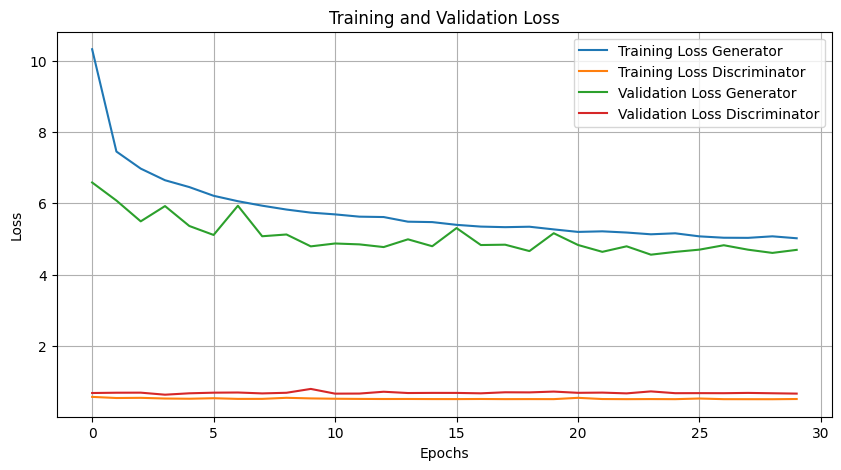

In [12]:
# Plot losses
def plot_losses(train_losses_G, train_losses_D, val_losses_G, val_losses_D):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_G, label='Training Loss Generator')
    plt.plot(train_losses_D, label='Training Loss Discriminator')
    plt.plot(val_losses_G, label='Validation Loss Generator')
    plt.plot(val_losses_D, label='Validation Loss Discriminator')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses_G, train_losses_D, val_losses_G, val_losses_D)


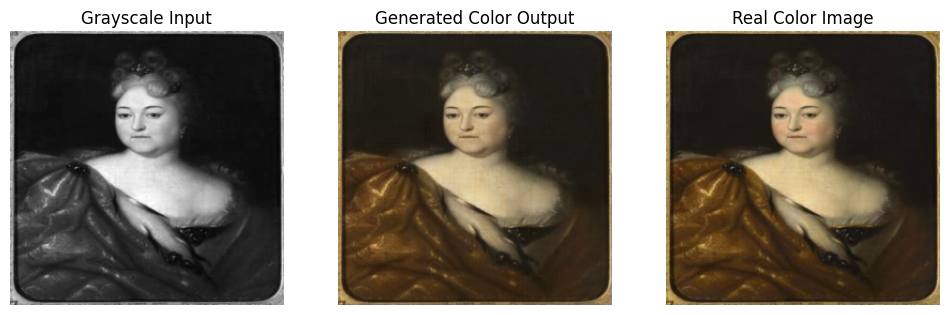

In [16]:
def visualize_model_outputs(model, data_loader, device, num_images=1):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.net_G(inputs)  # Assuming net_G is your generator model

            # Process only the first 'num_images' in the batch
            for i in range(min(num_images, inputs.size(0))):
                # Convert tensors to numpy arrays
                input_np = inputs[i].cpu().numpy().squeeze()
                output_np = outputs[i].cpu().numpy().squeeze()
                target_np = targets[i].cpu().numpy().squeeze()

                # Plotting
                fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

                # Display grayscale input image
                axs[0].imshow(input_np, cmap='gray')
                axs[0].title.set_text('Grayscale Input')
                axs[0].axis('off')

                # Display generated image
                axs[1].imshow(output_np.transpose(1, 2, 0))  # Adjust dimensions as needed
                axs[1].title.set_text('Generated Color Output')
                axs[1].axis('off')

                # Display real color image
                axs[2].imshow(target_np.transpose(1, 2, 0))  # Adjust dimensions as needed
                axs[2].title.set_text('Real Color Image')
                axs[2].axis('off')

                plt.show()

            break  # Only show 'num_images' from the first batch

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_outputs(model, validation_loader, device, num_images=1)


In [22]:
save_path =  r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\gans_epoch_30_lr=2e-4'
torch.save(model.net_G.state_dict(), f'{save_path}/generator_weights.pth')
torch.save(model.net_D.state_dict(), f'{save_path}/discriminator_weights.pth')

In [23]:
import pandas as pd
data = {
    'Train Loss G': train_losses_G,
    'Train Loss D': train_losses_D,
    'Validation Loss G': val_losses_G,
    'Validation Loss D': val_losses_D
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv(r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\gans_epoch_30_lr=2e-4\loss_data.csv', index_label='Epoch')

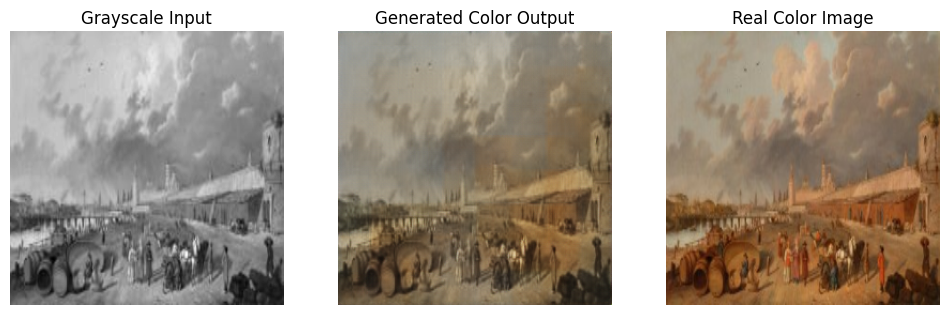

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the models
net_G = Generator().to(device)
net_D = Discriminator().to(device)

path_to_generator_weights = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\gans_epoch_30_lr=2e-4\generator_weights.pth'
path_to_discriminator_weights = r'C:\Users\Zhengqi Wang\Desktop\NYU\2024 Spring\301DL\Project\model\artifact\gans_epoch_30_lr=2e-4\discriminator_weights.pth'

# Load the weights
net_G.load_state_dict(torch.load(path_to_generator_weights))
net_D.load_state_dict(torch.load(path_to_discriminator_weights))

net_G.eval()
net_D.eval()

model = MainModel(net_G=net_G, net_D=net_D).to(device)

def visualize_model_outputs(model, data_loader, device, num_images=1):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.net_G(inputs)  # Assuming net_G is your generator model

            # Process only the first 'num_images' in the batch
            for i in range(min(num_images, inputs.size(0))):
                # Convert tensors to numpy arrays
                input_np = inputs[i].cpu().numpy().squeeze()
                output_np = outputs[i].cpu().numpy().squeeze()
                target_np = targets[i].cpu().numpy().squeeze()

                # Plotting
                fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

                # Display grayscale input image
                axs[0].imshow(input_np, cmap='gray')
                axs[0].title.set_text('Grayscale Input')
                axs[0].axis('off')

                # Display generated image
                axs[1].imshow(output_np.transpose(1, 2, 0))  # Adjust dimensions as needed
                axs[1].title.set_text('Generated Color Output')
                axs[1].axis('off')

                # Display real color image
                axs[2].imshow(target_np.transpose(1, 2, 0))  # Adjust dimensions as needed
                axs[2].title.set_text('Real Color Image')
                axs[2].axis('off')

                plt.show()

            break  # Only show 'num_images' from the first batch

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_outputs(model, validation_loader, device, num_images=1)